<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/HAFSA_ocean-atmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up environment

In [1]:
!pip install cfgrib
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 70.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tropycal: filename=tropycal-1.3-py3-none-any.whl size=242631 sha256=f4f54ff3a0884e4f991b3d3ad6229c90aaf8c1c1ee764458b6c96589a5903b02
  Stored in directory: /root/.cache/pip/wheels/45/b3/db/78c9a2a51e8db2d962647d8dd0bb4e1ed5e1005254353de4af
Successfully built tropycal


In [2]:
!sudo apt install aria2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 1s (1,232 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to front

In [29]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib
import cartopy.crs as ccrs
import cartopy.feature as cft
import subprocess as sp

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#User parameters

In [49]:
name = "Milton"
tcNum = "14"
trackType = ""

centralTime = dt(year=2024, month=10, day=7, hour=6) #Time when Milton began its most rapid intensification
daysBefore = 1 #Days before the focal point
daysAfter = 1 #Days after focal point
fHourStep = 6 #Normally 3 for HAFS-A
forecastLength = 36 #Normally 126 for HAFS-A. Changeable for testing.
runStep = 12 #Normally 6 for HAFS-A

figureSuffix = "_RI"
subfolder = "RITest/"
dataPath = "/content/drive/MyDrive/savedData/"
figurePath = "/content/drive/MyDrive/figures/"

Get ATCF data and find interested point

In [50]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]

ctStr = centralTime.strftime("%Y%m%d")
ctHour = centralTime.strftime("%H")

atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{ctStr}/{ctHour}/{tcNum}l.{ctStr}{ctHour}.hfsa.trak.atcfunix"
atcfFile = "atcf_" + ctStr + "_" + ctHour + ".csv"

!wget -O {atcfFile} {atcfURL}
atcf = pd.read_csv(atcfFile, names=cols)

--2025-06-17 15:08:43--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/06/14l.2024100706.hfsa.trak.atcfunix
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 3.5.11.197, 16.182.98.113, 3.5.8.222, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|3.5.11.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31106 (30K) [application/octet-stream]
Saving to: ‘atcf_20241007_06.csv’

atcf_20241007_06.cs 100%[===================>]  30.38K  --.-KB/s    in 0.03s   

2025-06-17 15:08:43 (1.13 MB/s) - ‘atcf_20241007_06.csv’ saved [31106/31106]



In [51]:
pointLat = int(atcf[atcf.TAU==0]["LatN/S"].iloc[0].replace("N", ""))/10
pointLon = int(atcf[atcf.TAU==0]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere

point = (pointLat, pointLon)
point

(22.1, -93.0)

#Retrieve HAFS-A Data

In [52]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

start = centralTime - pd.Timedelta(days=daysBefore)
end = centralTime + pd.Timedelta(days=daysAfter)

Find times needed

In [53]:
fcastTimes = {} #Key: initiation, item: valid time list

initTime = start
while initTime <= end:
  validTime = initTime
  fcastTimes[initTime] = []
  fhour = 0

  while validTime <= end and fhour <= forecastLength:
    fcastTimes[initTime].append(validTime)
    validTime += pd.Timedelta(hours=fHourStep)
    fhour += fHourStep

  initTime += pd.Timedelta(hours=runStep)

Get data from HAFS-A output.

In [59]:
fcastTimes

{datetime.datetime(2024, 10, 6, 6, 0): [datetime.datetime(2024, 10, 6, 6, 0),
  datetime.datetime(2024, 10, 6, 12, 0),
  datetime.datetime(2024, 10, 6, 18, 0),
  datetime.datetime(2024, 10, 7, 0, 0),
  datetime.datetime(2024, 10, 7, 6, 0),
  datetime.datetime(2024, 10, 7, 12, 0),
  datetime.datetime(2024, 10, 7, 18, 0)],
 datetime.datetime(2024, 10, 6, 18, 0): [datetime.datetime(2024, 10, 6, 18, 0),
  datetime.datetime(2024, 10, 7, 0, 0),
  datetime.datetime(2024, 10, 7, 6, 0),
  datetime.datetime(2024, 10, 7, 12, 0),
  datetime.datetime(2024, 10, 7, 18, 0),
  datetime.datetime(2024, 10, 8, 0, 0),
  datetime.datetime(2024, 10, 8, 6, 0)],
 datetime.datetime(2024, 10, 7, 6, 0): [datetime.datetime(2024, 10, 7, 6, 0),
  datetime.datetime(2024, 10, 7, 12, 0),
  datetime.datetime(2024, 10, 7, 18, 0),
  datetime.datetime(2024, 10, 8, 0, 0),
  datetime.datetime(2024, 10, 8, 6, 0)],
 datetime.datetime(2024, 10, 7, 18, 0): [datetime.datetime(2024, 10, 7, 18, 0),
  datetime.datetime(2024, 10, 8, 

In [65]:
atm = {}

for init, validList in fcastTimes.items():

  atm[init] = {}
  initTime = init.strftime("%Y%m%d%H")

  for valid in validList:
    atm[init][valid] = {}

    fhour = str(int((valid-init).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour

    atmFile = "hafsa_" + initTime + "_f" + fhour + ".nc"
    atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
    atmData = xr.open_dataset(atmPath)

    for layer in atmData.isobaricInhPa.data:
      #Longitude in atm files are in degrees east, but are -180 - 180 in oce files. point has them from -180 - 180
      validPoint = atmData.sel(latitude=point[0], longitude=point[1] + 360, isobaricInhPa=layer, method="nearest")
      atm[init][valid][layer] = {}
      atm[init][valid][layer]["T"] = float(validPoint.t.data)
      atm[init][valid][layer]["q"] = float(validPoint.q.data) * 1000 #Convert from kg/kg to g/kg
      atm[init][valid][layer]["u"] = float(validPoint.u.data)
      atm[init][valid][layer]["v"] = float(validPoint.v.data)
      atm[init][valid][layer]["gh"] = float(validPoint.gh.data)

<ipython-input-65-3857168424>:16: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
<ipython-input-65-3857168424>:16: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
<ipython-input-65-3857168424>:16: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
<ipython-input-65-3857168424>:16: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, Fa

In [66]:
atm

{datetime.datetime(2024, 10, 6, 6, 0): {datetime.datetime(2024, 10, 6, 6, 0): {np.float64(1000.0): {'T': 300.7799987792969,
    'q': 17.709486186504364,
    'u': -1.1299999952316284,
    'v': 3.640000104904175,
    'gh': 83.75459289550781},
   np.float64(975.0): {'T': 298.6700134277344,
    'q': 17.496054992079735,
    'u': -1.2400000095367432,
    'v': 3.700000047683716,
    'gh': 309.10205078125},
   np.float64(950.0): {'T': 296.95001220703125,
    'q': 16.121765598654747,
    'u': -1.309999942779541,
    'v': 3.9700000286102295,
    'gh': 537.6586303710938},
   np.float64(925.0): {'T': 295.9200134277344,
    'q': 14.76642768830061,
    'u': -1.4800000190734863,
    'v': 4.329999923706055,
    'gh': 771.089111328125},
   np.float64(900.0): {'T': 294.6600036621094,
    'q': 14.715099707245827,
    'u': -1.600000023841858,
    'v': 4.639999866485596,
    'gh': 1009.8947143554688},
   np.float64(875.0): {'T': 293.70001220703125,
    'q': 13.823023997247219,
    'u': -1.4199999570846558,

In [67]:
oce = {}

for init, validList in fcastTimes.items():

  oce[init] = {}
  initTime = init.strftime("%Y%m%d%H")

  for valid in validList:
    oce[init][valid] = {}

    fhour = str(int((valid-init).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour

    #oceURL = bucket + initDate + "/" + initHour + "/" + tcNum + "l." + initDate + initHour + ".hfsa.mom6.f" + fhour + ".nc"
    oceFile = "mom6_" + initTime + "_f" + fhour + ".nc"
    ocePath = dataPath + "mom6Output/" + subfolder + oceFile
    oceData = xr.open_dataset(ocePath, decode_times=False)

    for layer in oceData.z_l.data:
      oce[init][valid][layer] = {}
      oce[init][valid][layer]["T"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").temp.data) + 273.15 #This is potential temperature. Converted from C to K.
      oce[init][valid][layer]["s"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").so.data)
      oce[init][valid][layer]["u"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").uo.data)
      oce[init][valid][layer]["v"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").vo.data)

<ipython-input-67-1597750835>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  oce[init][valid][layer]["T"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").temp.data) + 273.15 #This is potential temperature. Converted from C to K.
<ipython-input-67-1597750835>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  oce[init][valid][layer]["s"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").so.data)
<ipython-input-67-1597750835>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future

In [68]:
oce

{datetime.datetime(2024, 10, 6, 6, 0): {datetime.datetime(2024, 10, 6, 6, 0): {np.float64(1.0): {'T': 303.07561149597166,
    's': 36.11821746826172,
    'u': 0.09251334518194199,
    'v': -0.009504452347755432},
   np.float64(3.5): {'T': 303.04504814147947,
    's': 36.11996841430664,
    'u': 0.07395867258310318,
    'v': -0.03961580991744995},
   np.float64(7.5): {'T': 303.04868545532224,
    's': 36.11960220336914,
    'u': 0.06274488568305969,
    'v': -0.04768035560846329},
   np.float64(12.824999809265137): {'T': 303.05556144714353,
    's': 36.11881637573242,
    'u': 0.049650248140096664,
    'v': -0.049495916813611984},
   np.float64(18.554999351501465): {'T': 303.0576652526855,
    's': 36.11813735961914,
    'u': 0.03644845262169838,
    'v': -0.044116731733083725},
   np.float64(24.894999504089355): {'T': 303.052904510498,
    's': 36.11769104003906,
    'u': 0.020682455971837044,
    'v': -0.024288786575198174},
   np.float64(32.33000087738037): {'T': 302.39209213256834,


Create figure of model parameters

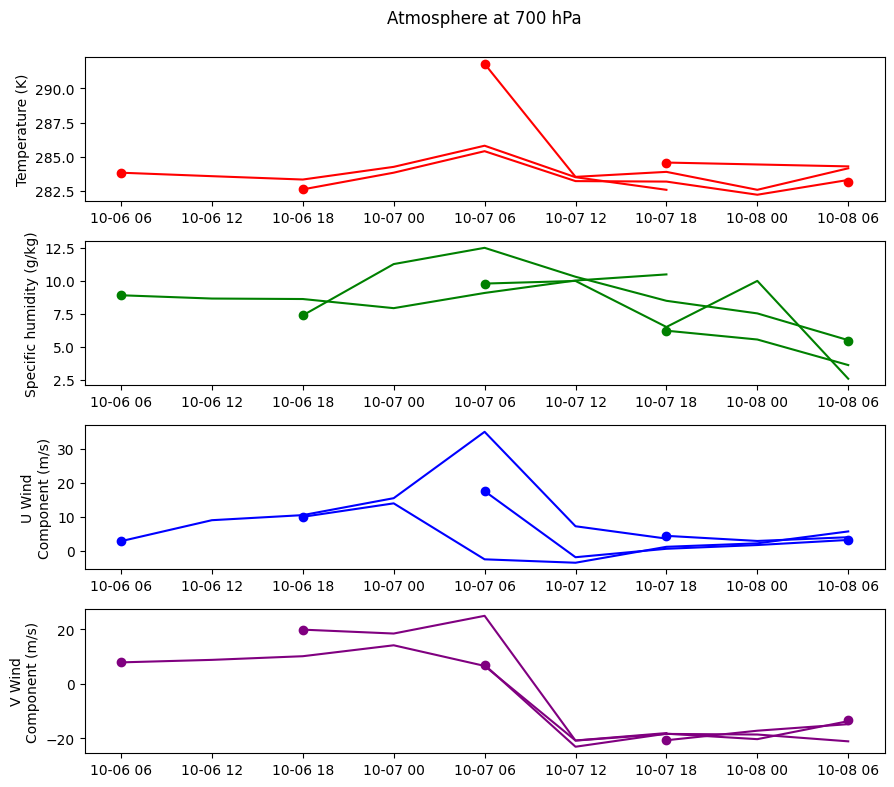

In [77]:
atmFig = plt.figure(figsize=(10,8))
tAx = atmFig.add_axes([0.1, 0.74, 0.8, 0.18])
qAx = atmFig.add_axes([0.1, 0.51, 0.8, 0.18])
uAx = atmFig.add_axes([0.1, 0.28, 0.8, 0.18])
vAx = atmFig.add_axes([0.1, 0.05, 0.8, 0.18])

atmLevel = 1000.0
for runTime, run in zip(atm.keys(), atm.values()):
  time = run.keys()
  t = [atm[runTime][timestep][atmLevel]["T"] for timestep in time]
  q = [atm[runTime][timestep][atmLevel]["q"] for timestep in time]
  u = [atm[runTime][timestep][atmLevel]["u"] for timestep in time]
  v = [atm[runTime][timestep][atmLevel]["v"] for timestep in time]

  tAx.plot(time, t, color="red")
  qAx.plot(time, q, color="green")
  uAx.plot(time, u, color="blue")
  vAx.plot(time, v, color="purple")

tAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["T"] for runTime in atm.keys()], color="red")
qAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["q"] for runTime in atm.keys()], color="green")
uAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["u"] for runTime in atm.keys()], color="blue")
vAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["v"] for runTime in atm.keys()], color="purple")

tAx.set_ylabel("Temperature (K)")
qAx.set_ylabel("Specific humidity (g/kg)")
uAx.set_ylabel("U Wind\nComponent (m/s)")
vAx.set_ylabel("V Wind\nComponent (m/s)")

atmFig.suptitle(f"Atmosphere at {int(atmLevel)} hPa")
plt.savefig(f"atmParameters_{int(atmLevel)}hPa{figureSuffix}.png")
plt.show()

In [74]:
windDir = {}
for runTime, run in zip(atm.keys(), atm.values()):
  windDir[runTime] = {}
  for time in run.keys():
    windDir[runTime][time] = np.arctan(atm[runTime][time][atmLevel]["u"] / atm[runTime][time][atmLevel]["v"]) * (180/np.pi) + 180

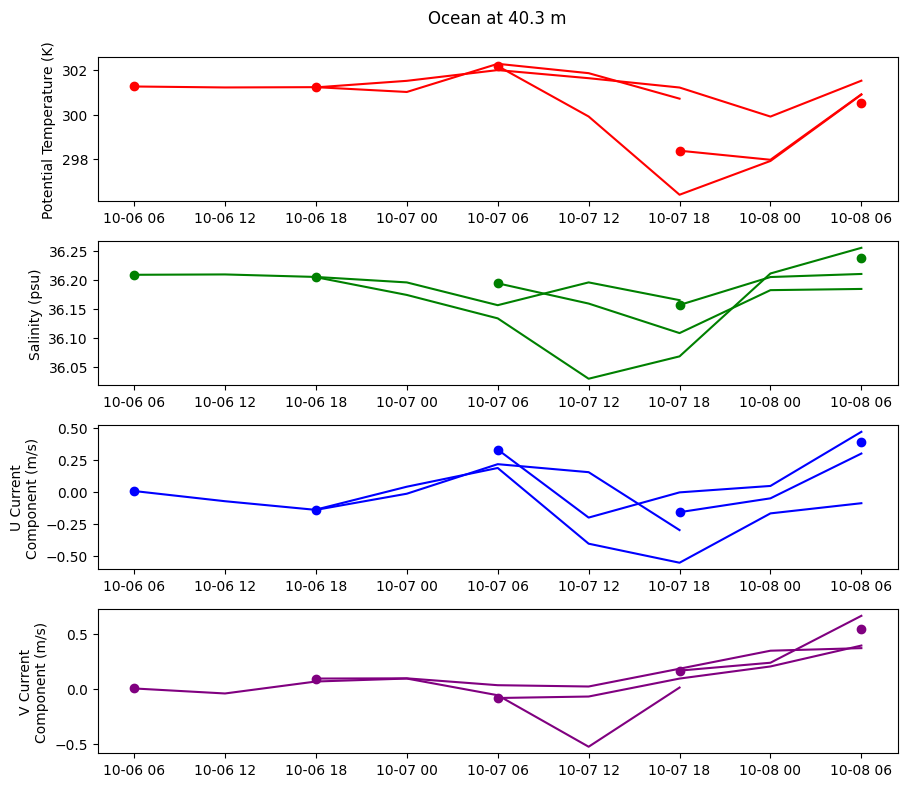

In [78]:
oceFig = plt.figure(figsize=(10,8))
tAx = oceFig.add_axes([0.1, 0.74, 0.8, 0.18])
sAx = oceFig.add_axes([0.1, 0.51, 0.8, 0.18])
uAx = oceFig.add_axes([0.1, 0.28, 0.8, 0.18])
vAx = oceFig.add_axes([0.1, 0.05, 0.8, 0.18])

oceLevel = 7.5
for runTime, run in zip(oce.keys(), oce.values()):
  time = run.keys()
  t = [oce[runTime][timestep][oceLevel]["T"] for timestep in time]
  s = [oce[runTime][timestep][oceLevel]["s"] for timestep in time]
  u = [oce[runTime][timestep][oceLevel]["u"] for timestep in time]
  v = [oce[runTime][timestep][oceLevel]["v"] for timestep in time]

  tAx.plot(time, t, color="red")
  sAx.plot(time, s, color="green")
  uAx.plot(time, u, color="blue")
  vAx.plot(time, v, color="purple")

tAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["T"] for runTime in oce.keys()], color="red")
sAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["s"] for runTime in oce.keys()], color="green")
uAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["u"] for runTime in oce.keys()], color="blue")
vAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["v"] for runTime in oce.keys()], color="purple")

tAx.set_ylabel("Potential Temperature (K)")
sAx.set_ylabel("Salinity (psu)")
uAx.set_ylabel("U Current\nComponent (m/s)")
vAx.set_ylabel("V Current\nComponent (m/s)")

oceFig.suptitle(f"Ocean at {round(oceLevel,1)} m")
plt.savefig(f"oceParameters_{int(oceLevel)}m{figureSuffix}.png")
plt.show()

In [75]:
currDir = {}
for runTime, run in zip(oce.keys(), oce.values()):
  currDir[runTime] = {}
  for time in run.keys():
    currDir[runTime][time] = np.arctan(oce[runTime][time][oceLevel]["u"] / oce[runTime][time][oceLevel]["v"]) * (180/np.pi) + 180

Text(0.5, 0, 'Time')

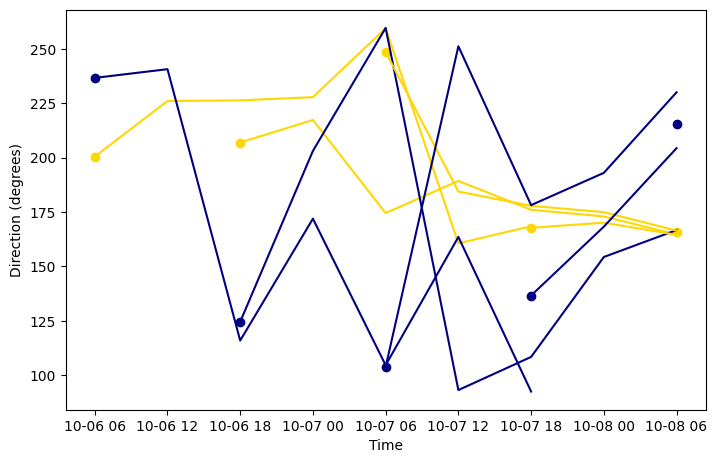

In [76]:
dirFig = plt.figure(figsize=(8,5))
dirAx = dirFig.add_axes([0.1, 0.1, 0.8, 0.8])

for runTime in windDir.keys():
  dirAx.plot(windDir[runTime].keys(), windDir[runTime].values(), color="gold")
  dirAx.plot(currDir[runTime].keys(), currDir[runTime].values(), color="navy")

dirAx.scatter(windDir.keys(), [windDir[runTime][runTime] for runTime in windDir.keys()], color="gold")
dirAx.scatter(currDir.keys(), [currDir[runTime][runTime] for runTime in currDir.keys()], color="navy")

dirAx.set_ylabel("Direction (degrees)")
dirAx.set_xlabel("Time")